In [1]:
import openslide
import geopandas as gpd
import json
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from PIL import Image
from large_image import getTileSource
import tifffile
import numpy as np
import os


In [ ]:
wsi_path = "../../data/raw/slide-2024-04-03T07-52-35-R1-S2.mrxs"
slide = openslide.OpenSlide(wsi_path)

print("Slide dimensions:", slide.dimensions)
print("Available levels:", slide.level_dimensions)

Slide dimensions: (76472, 181940)
Available levels: ((76472, 181940), (38236, 90970), (19118, 45485), (9559, 22742), (4779, 11371), (2389, 5685), (1194, 2842), (597, 1421), (298, 710))


In [ ]:
annotations = gpd.read_file("../../data/raw/slide-2024-04-03T07-52-35-R1-S2-rough.geojson")

print(annotations.head())

                                     id  objectType  name  \
0  7917b8ea-b045-4161-896a-a0f2d241a692  annotation  None   
1  c83b012d-d700-41af-8bc9-cbf37cd7292b  annotation  None   
2  bc41ec14-d659-4e9b-a7ca-3efb1b1d1caa  annotation  None   
3  aba594b6-e830-4b39-ac18-7bbddd5d60ba  annotation  None   
4  20e617a6-3971-4e8a-bf0c-54c0d6b12abd  annotation  None   

                                     classification metadata  \
0  { "name": "mitóza", "color": [ 236, 137, 104 ] }     None   
1  { "name": "mitóza", "color": [ 236, 137, 104 ] }     None   
2  { "name": "mitóza", "color": [ 236, 137, 104 ] }     None   
3  { "name": "mitóza", "color": [ 236, 137, 104 ] }     None   
4  { "name": "mitóza", "color": [ 236, 137, 104 ] }     None   

                                            geometry  
0  POLYGON ((38526 53586, 38525.91 53588.13, 3852...  
1  POLYGON ((39332 53612, 39331.88 53615.2, 39331...  
2  POLYGON ((37121 51187.5, 37120.94 51189.79, 37...  
3  POLYGON ((37834 51951.5, 

In [4]:
# loaded as strings -> converted to dicts
annotations["classification"] = annotations["classification"].apply(json.loads)

In [5]:
pleo_mask = annotations["classification"].apply(lambda cls: cls.get("name") == "nukleárny pleomorfizmus")
pleomorphisms = annotations[pleo_mask]
pleomorphisms

,id,objectType,name,classification,metadata,geometry
28,5cc45e68-1e60-4d40-9973-9a833f032716,annotation,None,"{'name': 'nukleárny pleomorfizmus', 'color': [...","{ ""ANNOTATION_DESCRIPTION"": ""stredný nárast ve...","POLYGON ((36742 53249, 36741.03 53259.67, 3673..."
29,6bacda35-cb3a-4141-900b-50b2be0b2b48,annotation,None,"{'name': 'nukleárny pleomorfizmus', 'color': [...","{ ""ANNOTATION_DESCRIPTION"": ""stredný nárast ve...","POLYGON ((37814 51559.5, 37813.44 51580.57, 37..."


In [6]:
# first pleomorphism
roi_polygon = pleomorphisms.geometry.iloc[0]

# get bounding box
minx, miny, maxx, maxy = roi_polygon.bounds

# add margin around BBox
margin = 200
x0, y0 = int(minx - margin), int(miny - margin)
x1, y1 = int(maxx + margin), int(maxy + margin)
width, height = x1 - x0, y1 - y0

print(f"{minx=} {miny=} {maxx=} {maxy=} {width=} {height=}")


minx=35761.0 miny=53079.0 maxx=36742.0 maxy=53419.0 width=1381 height=740


In [7]:
source = getTileSource(wsi_path)

metadata = source.getMetadata()
mpp_x = float(metadata.get("mm_x", 0)) * 1000  # convert mm to microns
mpp_y = float(metadata.get("mm_y", 0)) * 1000

print(f"WSI Resolution: {mpp_x} × {mpp_y} microns per pixel")

# define the region to extract
region = {
    'left': int(x0),
    'top': int(y0),
    'width': int(width),
    'height': int(height),
    'units': 'base_pixels'
}

print(f"Extracting region: {region}")

tile_image, _ = source.getRegion(region=region, format='PIL')

# Convert to RGB numpy array
tile_rgb = np.array(tile_image.convert("RGB"))

# Save as OME-TIFF with resolution and compression
tifffile.imwrite(
    'outpath.ome.tif',
    tile_rgb,
    photometric='rgb',
    tile=(256, 256),  # tiled like WSIs
    compression='deflate',
    resolution=(1 / mpp_x, 1 / mpp_y) if mpp_x > 0 and mpp_y > 0 else None,
    resolutionunit='CENTIMETER',
    metadata={'axes': 'YXS'},
    ome=True
)


WSI Resolution: 0.274358240290104 × 0.274358240290104 microns per pixel
Extracting region: {'left': 35561, 'top': 52879, 'width': 1381, 'height': 740, 'units': 'base_pixels'}


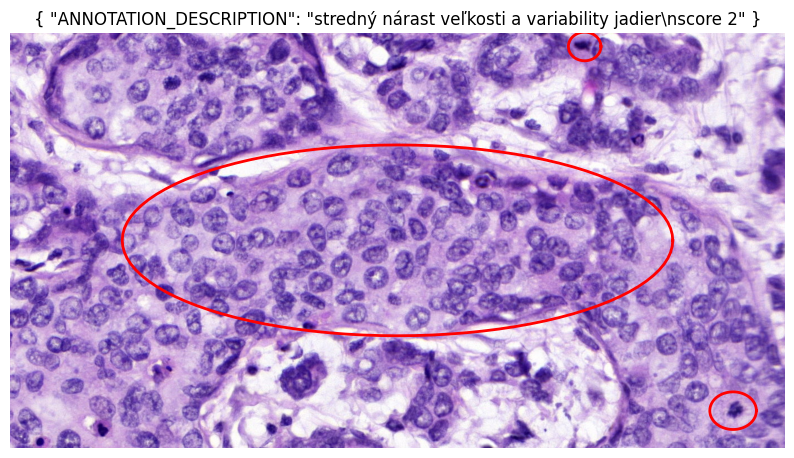

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(tile_rgb, extent=[x0, x1, y1, y0])

for poly in annotations.geometry:
    if poly.intersects(roi_polygon.buffer(500)):  # only nearby shapes
        x, y = poly.exterior.xy
        ax.plot(x, y, color='red', linewidth=2)

ax.set_xlim(x0, x1)
ax.set_ylim(y1, y0)  # Flip y to match WSI coordinates
ax.axis('off')
ax.set_title(pleomorphisms.iloc[0].metadata)
plt.show()


# Extract this annotation and perform instance segmentation

In [26]:
from shapely.affinity import translate

def remap_annotations(gdf, offset_x, offset_y):
    """
    Return a copy of a GeoDataFrame with geometries shifted by the given offsets.
    """
    remapped = gdf.copy()
    remapped["geometry"] = remapped["geometry"].apply(
        lambda geom: translate(geom, xoff=-offset_x, yoff=-offset_y)
    )
    return remapped

def extract_region_from_wsi(wsi_path, output_path, x_min, y_min, width, height, level=0):
    """
    Extract a region from the WSI image and save it using large_image.
    
    Args:
        wsi_path: Path to the WSI file (.mrxs format)
        output_path: Path to save the extracted region (as .ome.tif)
        x_min, y_min: Top-left coordinates of the region to extract
        width, height: Width and height of the region to extract
        level: Not used with large_image, but kept for compatibility
    """
    # Make sure the output directory exists
    os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
    
    # Open the WSI file with large_image
    source = getTileSource(wsi_path)
    
    # Get metadata for resolution information
    metadata = source.getMetadata()
    mpp_x = float(metadata.get("mm_x", 0)) * 1000  # convert mm to microns
    mpp_y = float(metadata.get("mm_y", 0)) * 1000
    
    print(f"WSI Resolution: {mpp_x} × {mpp_y} microns per pixel")
    
    # Define the region to extract
    region = {
        'left': int(x_min),
        'top': int(y_min),
        'width': int(width),
        'height': int(height),
        'units': 'base_pixels'
    }
    
    print(f"Extracting region: {region}")
    
    # Get the region as a PIL image
    tile_image, _ = source.getRegion(region=region, format='PIL')
    
    # Convert to RGB numpy array
    tile_rgb = np.array(tile_image.convert("RGB"))
    
    # Save as OME-TIFF with resolution and compression
    tifffile.imwrite(
        output_path,
        tile_rgb,
        photometric='rgb',
        tile=(256, 256),  # tiled like WSIs
        compression='deflate',
        resolution=(1 / mpp_x, 1 / mpp_y) if mpp_x > 0 and mpp_y > 0 else None,
        resolutionunit='CENTIMETER',
        metadata={'axes': 'YXS'},
        ome=True
    )
    
    print(f"Extracted region saved to {output_path}")
    return output_path

In [ ]:
remapped_geojson = remap_annotations(annotations, x0, y0)

print(f"{x0=} {y0=}")
print(remapped_geojson.geometry.iloc[28])
print(annotations.geometry.iloc[28])

GEOJSON_PATH = '../../data/raw/slide-2024-04-03T07-52-35-R1-S2-rough.geojson'
OUT_DIR = '../../outputs'

REMAPPED_GEOJSON = f'remapped_{os.path.basename(GEOJSON_PATH)}'
remapped_geojson.to_file(
    os.path.join(OUT_DIR, REMAPPED_GEOJSON),
    driver="GeoJSON"
)


x0=35561 y0=52879
POLYGON ((1181 370, 1180.0299999999988 380.66999999999825, 1177.1299999999974 391.3099999999977, 1172.3099999999977 401.84999999999854, 1165.5899999999965 412.27999999999884, 1156.989999999998 422.52999999999884, 1146.5599999999977 432.58000000000175, 1134.3199999999997 442.3799999999974, 1120.3300000000017 451.90000000000146, 1104.6399999999994 461.0899999999965, 1087.3199999999997 469.91999999999825, 1068.4400000000023 478.3600000000006, 1048.0599999999977 486.3700000000026, 1026.2699999999968 493.91999999999825, 1003.1600000000035 500.98999999999796, 978.8099999999977 507.52999999999884, 953.3199999999997 513.5400000000009, 926.8000000000029 518.9700000000012, 899.3399999999965 523.8199999999997, 871.0699999999997 528.0599999999977, 842.0699999999997 531.6800000000003, 812.4800000000032 534.6600000000035, 782.4100000000035 536.989999999998, 751.9800000000032 538.6600000000035, 721.3000000000029 539.6600000000035, 690.5 540, 659.6999999999971 539.6600000000035, 629.

In [ ]:
import shutil

INPUT_WSI_PATH = '../../data/raw/slide-2024-04-03T07-52-35-R1-S2.mrxs'
OUTPUT_WSI_PATH = '../../outputs/remapped_slide-2024-04-03T07-52-35-R1-S2-rough.ome.tif'
INFERENCE_INPUT_DATA_DIR = os.path.join(OUT_DIR, 'segmentation', 'inference-inputs')

extract_region_from_wsi(INPUT_WSI_PATH, OUTPUT_WSI_PATH, x0, y0, width, height, level=0)

shutil.copy(OUTPUT_WSI_PATH, os.path.join(INFERENCE_INPUT_DATA_DIR, os.path.basename(OUTPUT_WSI_PATH)))

WSI Resolution: 0.274358240290104 × 0.274358240290104 microns per pixel
Extracting region: {'left': 35561, 'top': 52879, 'width': 1381, 'height': 740, 'units': 'base_pixels'}
Extracted region saved to ./outputs/remapped_slide-2024-04-03T07-52-35-R1-S2-rough.ome.tif


'./outputs/remapped_slide-2024-04-03T07-52-35-R1-S2-rough.ome.tif'

# After segmenting

(using main.py)

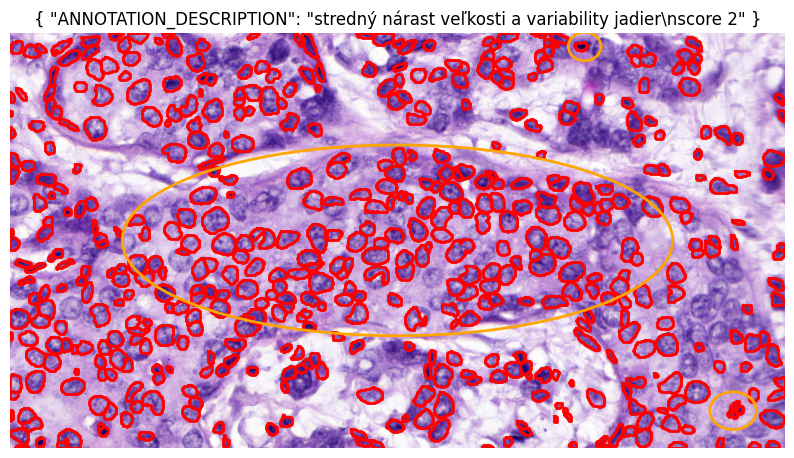

In [ ]:
inferred_annotations = gpd.read_file("../../outputs/segmentation/inference-inputs/remapped_slide-2024-04-03T07-52-35-R1-S2-rough.ome_instanseg_prediction.geojson")

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(tile_rgb, extent=[x0, x1, y1, y0])

for poly in inferred_annotations.geometry:
    x, y = poly.exterior.xy
    ax.plot(np.array(x)+x0, np.array(y)+y0, color='red', linewidth=2)


for poly in annotations.geometry:
    if poly.intersects(roi_polygon.buffer(500)):  # only nearby shapes
        x, y = poly.exterior.xy
        ax.plot(x, y, color='orange', linewidth=2)


ax.set_xlim(x0, x1)
ax.set_ylim(y1, y0)  # Flip y to match WSI coordinates
ax.axis('off')
ax.set_title(pleomorphisms.iloc[0].metadata)
plt.show()
